In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 128
use_gpu = True
y_scale = True
lr = 0.001
weight_decay = 0.01

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2, step3])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.transform(X_test)
print(X_test.shape)

(60000, 211)
(10000, 211)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [13]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 211])
torch.Size([10000, 211])
torch.Size([42000, 1])


In [15]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [16]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(211, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [17]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [18]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    with torch.no_grad():
        pred = model(X)
        
        pred = pred.cpu().numpy()
        if y_scale:
            pred = y_scaler.inverse_transform(pred)            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [19]:
train_losses = []
eval_losses = []
accs = []
for t in range(10000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 0.006945249672319548
epochs 1
training loss 0.00595250083161886
epochs 2
training loss 0.0059379568584631325
epochs 3
training loss 0.005865973004318298
epochs 4
training loss 0.006180385866847829
epochs 5
training loss 0.0060228948799134615
epochs 6
training loss 0.0061420825837989615
epochs 7
training loss 0.0060436734384758046
epochs 8
training loss 0.005915349492333309
epochs 9
training loss 0.00570465459900209
testing loss 0.006474792667506064
epochs 10
training loss 0.005659835240952274
epochs 11
training loss 0.005982396619586914
epochs 12
training loss 0.005518871669142329
epochs 13
training loss 0.0055255582290744025
epochs 14
training loss 0.005405251440269402
epochs 15
training loss 0.005433729455571361
epochs 16
training loss 0.005245295941679651
epochs 17
training loss 0.005313968794748731
epochs 18
training loss 0.005330270606710216
epochs 19
training loss 0.005317327511244903
testing loss 0.006586060592581036
epochs 20
training loss 0.0052799062165

training loss 0.003451289671351482
epochs 169
training loss 0.0028107154595674124
testing loss 0.004404454444971015
epochs 170
training loss 0.0030585665632277092
epochs 171
training loss 0.002873624799175805
epochs 172
training loss 0.0032626808635850854
epochs 173
training loss 0.002885678844628318
epochs 174
training loss 0.0028767445932162254
epochs 175
training loss 0.0034766717712001417
epochs 176
training loss 0.003366151740024359
epochs 177
training loss 0.0031649982397470022
epochs 178
training loss 0.003067083209880421
epochs 179
training loss 0.002557047160475382
testing loss 0.004036947283547055
epochs 180
training loss 0.0027352753328867144
epochs 181
training loss 0.002792833025827664
epochs 182
training loss 0.00518904309712724
epochs 183
training loss 0.004685337618446278
epochs 184
training loss 0.0036632823538442784
epochs 185
training loss 0.004252670120127997
epochs 186
training loss 0.0031881489190145602
epochs 187
training loss 0.004565823909551992
epochs 188
trai

training loss 0.0018410472794489702
epochs 333
training loss 0.0017961073442295725
epochs 334
training loss 0.0017847046015450113
epochs 335
training loss 0.0018322322721802558
epochs 336
training loss 0.001746218114218032
epochs 337
training loss 0.002104879749866661
epochs 338
training loss 0.002075329447719962
epochs 339
training loss 0.002066440912498597
testing loss 0.0038056622824056987
epochs 340
training loss 0.0018729754632670081
epochs 341
training loss 0.0018101175719770208
epochs 342
training loss 0.001670956150925857
epochs 343
training loss 0.001774777750106738
epochs 344
training loss 0.0017001269187772573
epochs 345
training loss 0.0016405804008089776
epochs 346
training loss 0.0016352405672890096
epochs 347
training loss 0.0017422435422694044
epochs 348
training loss 0.0017033016980034059
epochs 349
training loss 0.0015269874387751914
testing loss 0.003641371044713396
epochs 350
training loss 0.0018531388568120094
epochs 351
training loss 0.0016619444854478252
epochs 3

training loss 0.0012731990415325507
epochs 497
training loss 0.001278457936680788
epochs 498
training loss 0.001239056996208556
epochs 499
training loss 0.0015473544854517902
testing loss 0.002878540167865733
epochs 500
training loss 0.001308801528215012
epochs 501
training loss 0.0012746226820262506
epochs 502
training loss 0.0012291322818229762
epochs 503
training loss 0.0012743897954749345
epochs 504
training loss 0.0018812123200244704
epochs 505
training loss 0.0013624902354273096
epochs 506
training loss 0.0012542393356122891
epochs 507
training loss 0.0012984251165422851
epochs 508
training loss 0.0013400273538041736
epochs 509
training loss 0.0014299580933155329
testing loss 0.002865246254769121
epochs 510
training loss 0.0015223752537396904
epochs 511
training loss 0.0012911277487704185
epochs 512
training loss 0.0013117513769393997
epochs 513
training loss 0.001248029030407963
epochs 514
training loss 0.0012575580535377276
epochs 515
training loss 0.0013680121870952061
epochs 

training loss 0.0010685803613549036
epochs 661
training loss 0.0009962335382135284
epochs 662
training loss 0.0011158080202404205
epochs 663
training loss 0.0011094235762030928
epochs 664
training loss 0.001084389632120502
epochs 665
training loss 0.0011276850516845594
epochs 666
training loss 0.0012361528866748838
epochs 667
training loss 0.0012513907452179035
epochs 668
training loss 0.0013188247377474687
epochs 669
training loss 0.0010982540161504572
testing loss 0.002839166083594401
epochs 670
training loss 0.0012039613574219578
epochs 671
training loss 0.0010310715272467822
epochs 672
training loss 0.0010636909854227514
epochs 673
training loss 0.0010497772614655614
epochs 674
training loss 0.001038481366019526
epochs 675
training loss 0.0010874075125081968
epochs 676
training loss 0.0010445447090877316
epochs 677
training loss 0.0011011731982836924
epochs 678
training loss 0.0012085279670974245
epochs 679
training loss 0.0011129234729923513
testing loss 0.0034034026750356804
epoc

training loss 0.0010442433804117913
epochs 825
training loss 0.0010527369681615551
epochs 826
training loss 0.0013627085097326606
epochs 827
training loss 0.0024128538024920324
epochs 828
training loss 0.0012494294900987806
epochs 829
training loss 0.0010603394751765376
testing loss 0.0026131754977205862
epochs 830
training loss 0.0010450831467588644
epochs 831
training loss 0.0009581043855938211
epochs 832
training loss 0.000972415849221106
epochs 833
training loss 0.0011125191678873357
epochs 834
training loss 0.0011736901441948505
epochs 835
training loss 0.0010531057957857055
epochs 836
training loss 0.0010093386148068613
epochs 837
training loss 0.0009733537013152767
epochs 838
training loss 0.0009195976152854737
epochs 839
training loss 0.0009777626351065549
testing loss 0.002497130170619736
epochs 840
training loss 0.0009597756170616754
epochs 841
training loss 0.0010247921948335318
epochs 842
training loss 0.0011128485615019854
epochs 843
training loss 0.0009911046793336178
epo

training loss 0.0010523233243538842
epochs 989
training loss 0.0009205072794794629
testing loss 0.0024836701353357984
epochs 990
training loss 0.0008966179679064392
epochs 991
training loss 0.0009841246000175453
epochs 992
training loss 0.0009905405993301615
epochs 993
training loss 0.0009448322949444133
epochs 994
training loss 0.0009000785463053654
epochs 995
training loss 0.001011053708843366
epochs 996
training loss 0.0009192203671889419
epochs 997
training loss 0.0009259207614366316
epochs 998
training loss 0.0008921077945389952
epochs 999
training loss 0.0008748189131637305
testing loss 0.0024929203713107985
epochs 1000
training loss 0.0009733326959573751
epochs 1001
training loss 0.0008857719349677711
epochs 1002
training loss 0.00115196824591822
epochs 1003
training loss 0.0008946599834740139
epochs 1004
training loss 0.0009615686909638142
epochs 1005
training loss 0.0009051703231898915
epochs 1006
training loss 0.0008908795348706862
epochs 1007
training loss 0.0010404339320087

training loss 0.0009199323222511038
testing loss 0.002654409640409211
epochs 1150
training loss 0.0009106923683615837
epochs 1151
training loss 0.0017499550754178916
epochs 1152
training loss 0.001490860603329383
epochs 1153
training loss 0.0012863729196695448
epochs 1154
training loss 0.0010205009972710604
epochs 1155
training loss 0.0008915281170939511
epochs 1156
training loss 0.0008597640879027613
epochs 1157
training loss 0.0008824709036789472
epochs 1158
training loss 0.0009132885683036345
epochs 1159
training loss 0.0008578260212826704
testing loss 0.00261884915282461
epochs 1160
training loss 0.0007985690271582364
epochs 1161
training loss 0.0008517615164497069
epochs 1162
training loss 0.0008308966325646929
epochs 1163
training loss 0.0009189999065578471
epochs 1164
training loss 0.0010375019993015923
epochs 1165
training loss 0.0008964974353214483
epochs 1166
training loss 0.0010250814255159972
epochs 1167
training loss 0.0009088503324396987
epochs 1168
training loss 0.000888

training loss 0.0008040952981353417
testing loss 0.002592321127365799
epochs 1310
training loss 0.0009849912930693261
epochs 1311
training loss 0.002237362539081475
epochs 1312
training loss 0.0012433304805959658
epochs 1313
training loss 0.0009200116914929114
epochs 1314
training loss 0.0008284046568010444
epochs 1315
training loss 0.0008580819197638827
epochs 1316
training loss 0.0008375701449576505
epochs 1317
training loss 0.0008516312442545844
epochs 1318
training loss 0.0008935475283893997
epochs 1319
training loss 0.0008509348638109455
testing loss 0.002456638624756234
epochs 1320
training loss 0.0008878619467597568
epochs 1321
training loss 0.0009217524866001697
epochs 1322
training loss 0.0009199626093424608
epochs 1323
training loss 0.0008702696774135087
epochs 1324
training loss 0.0009923407165361936
epochs 1325
training loss 0.0011011371925992658
epochs 1326
training loss 0.0008739434204051572
epochs 1327
training loss 0.0008532583223808682
epochs 1328
training loss 0.00096

training loss 0.0009348673196997788
testing loss 0.0028933838900700474
epochs 1470
training loss 0.0011076722672707358
epochs 1471
training loss 0.0009331392937433258
epochs 1472
training loss 0.0008313285009433037
epochs 1473
training loss 0.0008265345543481432
epochs 1474
training loss 0.0008171415177604189
epochs 1475
training loss 0.0009076778530489971
epochs 1476
training loss 0.000782398084683859
epochs 1477
training loss 0.0008027864373105049
epochs 1478
training loss 0.0009383280162832566
epochs 1479
training loss 0.0008212790002134886
testing loss 0.002482148024405465
epochs 1480
training loss 0.0008458311025174985
epochs 1481
training loss 0.0008360086313921585
epochs 1482
training loss 0.0008160660443558587
epochs 1483
training loss 0.0007963097710190709
epochs 1484
training loss 0.0009501186563239906
epochs 1485
training loss 0.0009153491861999352
epochs 1486
training loss 0.0008100681093600678
epochs 1487
training loss 0.000793545272294715
epochs 1488
training loss 0.00093

training loss 0.0008046810649155631
testing loss 0.002607641004749197
epochs 1630
training loss 0.0007909205406911298
epochs 1631
training loss 0.000859085255653504
epochs 1632
training loss 0.0007916531934421283
epochs 1633
training loss 0.000945207688888099
epochs 1634
training loss 0.0009364779020580364
epochs 1635
training loss 0.0010374589190863663
epochs 1636
training loss 0.0010769359180406528
epochs 1637
training loss 0.0013833288027265175
epochs 1638
training loss 0.0008593111548970501
epochs 1639
training loss 0.0008175166413657888
testing loss 0.0028653651837536945
epochs 1640
training loss 0.0010085383774769297
epochs 1641
training loss 0.0007856715171375683
epochs 1642
training loss 0.0007878691004907662
epochs 1643
training loss 0.0007588068042962464
epochs 1644
training loss 0.0007611029764770397
epochs 1645
training loss 0.0008632936345067974
epochs 1646
training loss 0.0009156437593372114
epochs 1647
training loss 0.0008432940685396906
epochs 1648
training loss 0.00081

training loss 0.0007662803876230714
testing loss 0.002548347723898181
epochs 1790
training loss 0.000885688726143419
epochs 1791
training loss 0.0008900174785279429
epochs 1792
training loss 0.000835004760487441
epochs 1793
training loss 0.0007834349438515534
epochs 1794
training loss 0.0009772341955300297
epochs 1795
training loss 0.000814854440747797
epochs 1796
training loss 0.0007858246947549521
epochs 1797
training loss 0.0007839300390191399
epochs 1798
training loss 0.0008115284489878202
epochs 1799
training loss 0.0007689391505390712
testing loss 0.0026110544518389285
epochs 1800
training loss 0.0007520011494553288
epochs 1801
training loss 0.0008565376552160105
epochs 1802
training loss 0.0009665557271432935
epochs 1803
training loss 0.0008353044673988715
epochs 1804
training loss 0.0008094432909893704
epochs 1805
training loss 0.0008546796614604246
epochs 1806
training loss 0.0007881128264054667
epochs 1807
training loss 0.0008237643335807196
epochs 1808
training loss 0.000747

training loss 0.0007775100405394499
testing loss 0.0027994253009670012
epochs 1950
training loss 0.0010766329500848275
epochs 1951
training loss 0.0007932860453614518
epochs 1952
training loss 0.0007993920110335919
epochs 1953
training loss 0.0008295785026563937
epochs 1954
training loss 0.0007451170467874913
epochs 1955
training loss 0.000804377954802122
epochs 1956
training loss 0.0007731152995982091
epochs 1957
training loss 0.0007735605301734592
epochs 1958
training loss 0.0007526797601085519
epochs 1959
training loss 0.0007834908922059932
testing loss 0.0027511936640499013
epochs 1960
training loss 0.0007948716362870346
epochs 1961
training loss 0.0007638340280002045
epochs 1962
training loss 0.0008860674822429834
epochs 1963
training loss 0.0008118137126147328
epochs 1964
training loss 0.0007522247694885659
epochs 1965
training loss 0.0007644880787359046
epochs 1966
training loss 0.0007557043864810697
epochs 1967
training loss 0.0006996848417720602
epochs 1968
training loss 0.000

training loss 0.0007443260862371717
testing loss 0.0026857362757106676
epochs 2110
training loss 0.0007643843065072587
epochs 2111
training loss 0.0007774054656996983
epochs 2112
training loss 0.0007722198761119239
epochs 2113
training loss 0.0007162311570478269
epochs 2114
training loss 0.0007618020659653713
epochs 2115
training loss 0.0008123785536523942
epochs 2116
training loss 0.0007572000761166792
epochs 2117
training loss 0.0007964181980913602
epochs 2118
training loss 0.0007433563204217521
epochs 2119
training loss 0.0008281778211041571
testing loss 0.002584321501562438
epochs 2120
training loss 0.0007912499296173205
epochs 2121
training loss 0.0007861844556955309
epochs 2122
training loss 0.0008904025520164078
epochs 2123
training loss 0.0008739649203512534
epochs 2124
training loss 0.0007720565261307956
epochs 2125
training loss 0.0007413673596944955
epochs 2126
training loss 0.0007364167851299659
epochs 2127
training loss 0.0007532283583780508
epochs 2128
training loss 0.000

training loss 0.0007460160932141303
testing loss 0.002516900642910404
epochs 2270
training loss 0.0008096251932912617
epochs 2271
training loss 0.0012159584281898153
epochs 2272
training loss 0.0010621179750480755
epochs 2273
training loss 0.0008929032275253641
epochs 2274
training loss 0.0008012734158573202
epochs 2275
training loss 0.0008686128445571192
epochs 2276
training loss 0.0007500687790475502
epochs 2277
training loss 0.0007089153468243688
epochs 2278
training loss 0.0007285162255218915
epochs 2279
training loss 0.00077230814511047
testing loss 0.0028851326597946966
epochs 2280
training loss 0.00078013814889506
epochs 2281
training loss 0.0007789251412262172
epochs 2282
training loss 0.0007655747970997846
epochs 2283
training loss 0.0007329094358139577
epochs 2284
training loss 0.000953536144865388
epochs 2285
training loss 0.0009377005806024325
epochs 2286
training loss 0.0008269579206044166
epochs 2287
training loss 0.0007631977665164483
epochs 2288
training loss 0.00077842

training loss 0.0007565611861766483
testing loss 0.002559716212612755
epochs 2430
training loss 0.0007681962913666543
epochs 2431
training loss 0.0007294900256235967
epochs 2432
training loss 0.0008316300599729659
epochs 2433
training loss 0.0007042996573869116
epochs 2434
training loss 0.000675155736536416
epochs 2435
training loss 0.000741429598103235
epochs 2436
training loss 0.0008000425440096509
epochs 2437
training loss 0.0008006880240653582
epochs 2438
training loss 0.0007673244356138116
epochs 2439
training loss 0.0007204877912904784
testing loss 0.0025519555276061626
epochs 2440
training loss 0.0007213606545312392
epochs 2441
training loss 0.0007426627607496687
epochs 2442
training loss 0.0007196767945663499
epochs 2443
training loss 0.0013158010993128794
epochs 2444
training loss 0.0014560456291452548
epochs 2445
training loss 0.0009295527827161673
epochs 2446
training loss 0.000712784690379751
epochs 2447
training loss 0.0007411059105201231
epochs 2448
training loss 0.000726

training loss 0.0007068363249572248
testing loss 0.002585871634734068
epochs 2590
training loss 0.0006865200289032538
epochs 2591
training loss 0.0007184200501210965
epochs 2592
training loss 0.0007695045197802938
epochs 2593
training loss 0.0008100540130215167
epochs 2594
training loss 0.0008238178138595674
epochs 2595
training loss 0.0008710942724379951
epochs 2596
training loss 0.001228599408114227
epochs 2597
training loss 0.0007227202648287045
epochs 2598
training loss 0.0007456346368275605
epochs 2599
training loss 0.0007016324316254763
testing loss 0.0026385703946443947
epochs 2600
training loss 0.000768187543940603
epochs 2601
training loss 0.0007732124641073421
epochs 2602
training loss 0.000686009961097589
epochs 2603
training loss 0.0007175385399465379
epochs 2604
training loss 0.000809867099641559
epochs 2605
training loss 0.0007084175727774579
epochs 2606
training loss 0.000919184112485419
epochs 2607
training loss 0.0008807338104196924
epochs 2608
training loss 0.00098895

training loss 0.0007806812693636672
testing loss 0.002765792895088646
epochs 2750
training loss 0.0007752281433894188
epochs 2751
training loss 0.0007559543954616123
epochs 2752
training loss 0.0007934678806979945
epochs 2753
training loss 0.0009162904632576432
epochs 2754
training loss 0.0007834782303589761
epochs 2755
training loss 0.0006568094481583855
epochs 2756
training loss 0.0007866472412766973
epochs 2757
training loss 0.0007815661104671986
epochs 2758
training loss 0.0007192486712934115
epochs 2759
training loss 0.0006903416329766921
testing loss 0.002681182030297763
epochs 2760
training loss 0.000728420433935095
epochs 2761
training loss 0.0006893548093089341
epochs 2762
training loss 0.000692764781365924
epochs 2763
training loss 0.0006984791986107837
epochs 2764
training loss 0.0007254783715026617
epochs 2765
training loss 0.0007456379066296432
epochs 2766
training loss 0.0008453713823039096
epochs 2767
training loss 0.0007286732613871944
epochs 2768
training loss 0.000751

training loss 0.0007542259057015633
testing loss 0.002817157226208439
epochs 2910
training loss 0.0007506935539836557
epochs 2911
training loss 0.0007980354037383532
epochs 2912
training loss 0.0007400474834679074
epochs 2913
training loss 0.000767054287136439
epochs 2914
training loss 0.000632413376354836
epochs 2915
training loss 0.0006896289433303111
epochs 2916
training loss 0.0007501722732417308
epochs 2917
training loss 0.000725647903261225
epochs 2918
training loss 0.0007113959405133869
epochs 2919
training loss 0.0010882592167334468
testing loss 0.0026770636236215844
epochs 2920
training loss 0.0008273014951268024
epochs 2921
training loss 0.0007030904877083064
epochs 2922
training loss 0.0006698025641736424
epochs 2923
training loss 0.001559156726332421
epochs 2924
training loss 0.0007312060189596165
epochs 2925
training loss 0.0006818608042931235
epochs 2926
training loss 0.000663147029101758
epochs 2927
training loss 0.0007596115720929651
epochs 2928
training loss 0.00067628

training loss 0.0007166731205633007
testing loss 0.0026457746115229126
epochs 3070
training loss 0.0006868754744269294
epochs 3071
training loss 0.0006267154795587584
epochs 3072
training loss 0.000784810009521452
epochs 3073
training loss 0.0007863453553818269
epochs 3074
training loss 0.0007311142207898969
epochs 3075
training loss 0.0006888461293755977
epochs 3076
training loss 0.0008839182203598773
epochs 3077
training loss 0.0011051820353484545
epochs 3078
training loss 0.0010957913627171476
epochs 3079
training loss 0.0007095566455707928
testing loss 0.00268150970289411
epochs 3080
training loss 0.0006230983882788625
epochs 3081
training loss 0.0006456669194604013
epochs 3082
training loss 0.0006715747386947455
epochs 3083
training loss 0.0007236578188076513
epochs 3084
training loss 0.0006643299725137391
epochs 3085
training loss 0.0006513692840925307
epochs 3086
training loss 0.0006532853469783356
epochs 3087
training loss 0.0006625294607694581
epochs 3088
training loss 0.00061

training loss 0.0007693678609309236
testing loss 0.002720340319367535
epochs 3230
training loss 0.0006942112912780586
epochs 3231
training loss 0.0006078264933811235
epochs 3232
training loss 0.0006818252492315309
epochs 3233
training loss 0.0006788180280996255
epochs 3234
training loss 0.000866663180104822
epochs 3235
training loss 0.0008103729847225567
epochs 3236
training loss 0.0006947459224512444
epochs 3237
training loss 0.0006366199980090771
epochs 3238
training loss 0.0006480157322435721
epochs 3239
training loss 0.0006389064752527917
testing loss 0.0026966143004820806
epochs 3240
training loss 0.0006808550221778985
epochs 3241
training loss 0.0006570221840667235
epochs 3242
training loss 0.0007140967887182265
epochs 3243
training loss 0.0006572364284204019
epochs 3244
training loss 0.000709770719193794
epochs 3245
training loss 0.0006826533695348853
epochs 3246
training loss 0.0007070572523996064
epochs 3247
training loss 0.0006581430789083242
epochs 3248
training loss 0.00066

training loss 0.0007068211212577326
testing loss 0.00278877427121162
epochs 3390
training loss 0.0006576607343146301
epochs 3391
training loss 0.000691918373241664
epochs 3392
training loss 0.0007231013462270149
epochs 3393
training loss 0.0007659057667443534
epochs 3394
training loss 0.0006691368478442341
epochs 3395
training loss 0.000667160563294756
epochs 3396
training loss 0.0007027355237689865
epochs 3397
training loss 0.0006496790762195267
epochs 3398
training loss 0.0006445847592517552
epochs 3399
training loss 0.0007038271214033117
testing loss 0.0026066616769543196
epochs 3400
training loss 0.0007431390337004839
epochs 3401
training loss 0.000704431136196768
epochs 3402
training loss 0.000777893539678764
epochs 3403
training loss 0.0007101993984472018
epochs 3404
training loss 0.0007459104975287755
epochs 3405
training loss 0.0008326729552220202
epochs 3406
training loss 0.0007293824300893206
epochs 3407
training loss 0.0006715963036600375
epochs 3408
training loss 0.00070316

training loss 0.0006705551364177436
testing loss 0.002734348143645767
epochs 3550
training loss 0.000674407590020697
epochs 3551
training loss 0.0006105329933906071
epochs 3552
training loss 0.0006741366695398946
epochs 3553
training loss 0.0007498514171340149
epochs 3554
training loss 0.0006928045525021659
epochs 3555
training loss 0.0006389875475552193
epochs 3556
training loss 0.0006471215824258307
epochs 3557
training loss 0.000655699754753051
epochs 3558
training loss 0.0006504057725929686
epochs 3559
training loss 0.0006914248853309029
testing loss 0.002813537854863106
epochs 3560
training loss 0.0006266108228921279
epochs 3561
training loss 0.0006782050373840873
epochs 3562
training loss 0.0007066886666291719
epochs 3563
training loss 0.000682493922651652
epochs 3564
training loss 0.0006726718913568438
epochs 3565
training loss 0.0007205680861933254
epochs 3566
training loss 0.0006464557067772775
epochs 3567
training loss 0.0006600838332538886
epochs 3568
training loss 0.0006179

training loss 0.000707129359395331
testing loss 0.002795752152348109
epochs 3710
training loss 0.0006569320614461003
epochs 3711
training loss 0.0006127780109451444
epochs 3712
training loss 0.0006779148235406138
epochs 3713
training loss 0.0007651852984137063
epochs 3714
training loss 0.0006319868382233504
epochs 3715
training loss 0.0006863744068702564
epochs 3716
training loss 0.0006196411196666128
epochs 3717
training loss 0.0006928708796894693
epochs 3718
training loss 0.0006167529592974151
epochs 3719
training loss 0.0006559990985300618
testing loss 0.0027051285237027663
epochs 3720
training loss 0.0006193603474065084
epochs 3721
training loss 0.0006220668196390838
epochs 3722
training loss 0.0006193189231019275
epochs 3723
training loss 0.0006976492961622367
epochs 3724
training loss 0.0006308099829080857
epochs 3725
training loss 0.0007002336174953095
epochs 3726
training loss 0.0006671036853869714
epochs 3727
training loss 0.0006373557402776401
epochs 3728
training loss 0.0006

training loss 0.0006235821663910144
testing loss 0.00292695917028947
epochs 3870
training loss 0.0006769642928802043
epochs 3871
training loss 0.0006475132668184225
epochs 3872
training loss 0.000664379749794584
epochs 3873
training loss 0.0006402139190130083
epochs 3874
training loss 0.0007007988650135209
epochs 3875
training loss 0.0006284568466580158
epochs 3876
training loss 0.0006561289500023344
epochs 3877
training loss 0.0006070392916480074
epochs 3878
training loss 0.0006241059773969592
epochs 3879
training loss 0.0006803559759662891
testing loss 0.0028083865313645426
epochs 3880
training loss 0.0006376989242425443
epochs 3881
training loss 0.0006422540069434588
epochs 3882
training loss 0.0006810029020135243
epochs 3883
training loss 0.0006374995520346909
epochs 3884
training loss 0.0006653904412571612
epochs 3885
training loss 0.0007658556155367871
epochs 3886
training loss 0.0009905137129638934
epochs 3887
training loss 0.0006779097516895032
epochs 3888
training loss 0.00067

training loss 0.000765924319330501
testing loss 0.0027091215849286013
epochs 4030
training loss 0.0006957581529668376
epochs 4031
training loss 0.0006482071862633886
epochs 4032
training loss 0.0006586265823475473
epochs 4033
training loss 0.0007790895362913971
epochs 4034
training loss 0.0006594433305724198
epochs 4035
training loss 0.0006424925664417151
epochs 4036
training loss 0.000599196226347385
epochs 4037
training loss 0.0006247980317198544
epochs 4038
training loss 0.0007158298925411715
epochs 4039
training loss 0.0006128026446395506
testing loss 0.0027396371815162084
epochs 4040
training loss 0.0007342443216555273
epochs 4041
training loss 0.0006219505531979459
epochs 4042
training loss 0.0006466664029405619
epochs 4043
training loss 0.0006751462593030661
epochs 4044
training loss 0.000758469928962555
epochs 4045
training loss 0.0006813586724562554
epochs 4046
training loss 0.0006811628316311126
epochs 4047
training loss 0.0006280285516813239
epochs 4048
training loss 0.00071

training loss 0.0006630592219606552
testing loss 0.0027065062887160806
epochs 4190
training loss 0.0006928506820734398
epochs 4191
training loss 0.0006649905112805553
epochs 4192
training loss 0.000697146878152446
epochs 4193
training loss 0.0006307270664489605
epochs 4194
training loss 0.0005967421352786881
epochs 4195
training loss 0.0007066247992020803
epochs 4196
training loss 0.0006207605746205285
epochs 4197
training loss 0.0006539092745418211
epochs 4198
training loss 0.0006808330186205353
epochs 4199
training loss 0.0007285942078644472
testing loss 0.002768356999108264
epochs 4200
training loss 0.0007056307138190081
epochs 4201
training loss 0.001034056217679301
epochs 4202
training loss 0.0006778816245623658
epochs 4203
training loss 0.0006266024260389644
epochs 4204
training loss 0.0006114114997667858
epochs 4205
training loss 0.0007293225814677537
epochs 4206
training loss 0.0007409636975275947
epochs 4207
training loss 0.0006489479478369367
epochs 4208
training loss 0.00065

training loss 0.0007120854363530467
testing loss 0.0027340382217026665
epochs 4350
training loss 0.000675669995912897
epochs 4351
training loss 0.0006657090340776363
epochs 4352
training loss 0.0006406232119307182
epochs 4353
training loss 0.0008019156392917071
epochs 4354
training loss 0.0006317810606958746
epochs 4355
training loss 0.0006312973840490527
epochs 4356
training loss 0.0006264578094592708
epochs 4357
training loss 0.0006261100998044999
epochs 4358
training loss 0.0006388908424266079
epochs 4359
training loss 0.0005633170606949194
testing loss 0.0027959273165382497
epochs 4360
training loss 0.0006470218393527039
epochs 4361
training loss 0.0006373789462035856
epochs 4362
training loss 0.0006437875541163422
epochs 4363
training loss 0.0005956000674446609
epochs 4364
training loss 0.0006436279146524435
epochs 4365
training loss 0.0006079085175734223
epochs 4366
training loss 0.0005931747938565751
epochs 4367
training loss 0.0006055142022782546
epochs 4368
training loss 0.000

training loss 0.0006299188063695098
testing loss 0.0028241200191761427
epochs 4510
training loss 0.0006744554098256747
epochs 4511
training loss 0.0006409005573695939
epochs 4512
training loss 0.0007161689825082837
epochs 4513
training loss 0.0006666816258838395
epochs 4514
training loss 0.000663815698187266
epochs 4515
training loss 0.00064276757145493
epochs 4516
training loss 0.0006525611271727886
epochs 4517
training loss 0.0008822065489869112
epochs 4518
training loss 0.001093598873507356
epochs 4519
training loss 0.000821037469470681
testing loss 0.0028766920205522727
epochs 4520
training loss 0.0006794219793777313
epochs 4521
training loss 0.0006322820374910581
epochs 4522
training loss 0.000594226395485549
epochs 4523
training loss 0.000670801221511941
epochs 4524
training loss 0.0007847913345930627
epochs 4525
training loss 0.0008114661943021663
epochs 4526
training loss 0.0007382656589481628
epochs 4527
training loss 0.0006453349195933111
epochs 4528
training loss 0.000611717

training loss 0.000650184802777533
testing loss 0.002792074957677553
epochs 4670
training loss 0.0006504796202454467
epochs 4671
training loss 0.0007364935822654685
epochs 4672
training loss 0.0008073454516823757
epochs 4673
training loss 0.000605547895225467
epochs 4674
training loss 0.0006262914908874361
epochs 4675
training loss 0.0006110871483686474
epochs 4676
training loss 0.0007093780606632662
epochs 4677
training loss 0.0006464633669231461
epochs 4678
training loss 0.0006182978731526294
epochs 4679
training loss 0.0005958143397521704
testing loss 0.0028360881958262507
epochs 4680
training loss 0.0006180453554042091
epochs 4681
training loss 0.0005962859919170161
epochs 4682
training loss 0.0007467631877458012
epochs 4683
training loss 0.0006872635077484133
epochs 4684
training loss 0.0006778965874696801
epochs 4685
training loss 0.0006099353633937072
epochs 4686
training loss 0.0006115300813335982
epochs 4687
training loss 0.0006265417002332553
epochs 4688
training loss 0.00059

training loss 0.0007732954612433469
testing loss 0.0027255134199620458
epochs 4830
training loss 0.0006235885565837217
epochs 4831
training loss 0.0006509165501251738
epochs 4832
training loss 0.00060713677895312
epochs 4833
training loss 0.000634134325745875
epochs 4834
training loss 0.0006108066372468638
epochs 4835
training loss 0.0007161578190219971
epochs 4836
training loss 0.0007186565167089431
epochs 4837
training loss 0.0005811139317385083
epochs 4838
training loss 0.0006185977814024127
epochs 4839
training loss 0.0006045758689535742
testing loss 0.0027246068013792343
epochs 4840
training loss 0.0006723260561126004
epochs 4841
training loss 0.0007041365676594892
epochs 4842
training loss 0.0006452700507821442
epochs 4843
training loss 0.0006607818045889772
epochs 4844
training loss 0.0006214812367703018
epochs 4845
training loss 0.0006285063842966824
epochs 4846
training loss 0.0006844020166609855
epochs 4847
training loss 0.0006365832035135375
epochs 4848
training loss 0.00061

training loss 0.0006957954011813632
testing loss 0.002774433575484717
epochs 4990
training loss 0.0007177924785634226
epochs 4991
training loss 0.0006349852501830839
epochs 4992
training loss 0.0007012059476324229
epochs 4993
training loss 0.0006420357547534805
epochs 4994
training loss 0.0006612466759151726
epochs 4995
training loss 0.000653509248849882
epochs 4996
training loss 0.0008000154906280882
epochs 4997
training loss 0.0005898972904050615
epochs 4998
training loss 0.0006586178074099723
epochs 4999
training loss 0.0005580108459029732
testing loss 0.0027843160387161616
epochs 5000
training loss 0.000613837312969965
epochs 5001
training loss 0.0006406253777333962
epochs 5002
training loss 0.0008442015767502273
epochs 5003
training loss 0.0006580008754696368
epochs 5004
training loss 0.0006282426356543195
epochs 5005
training loss 0.0006282087296918374
epochs 5006
training loss 0.0006167915753919721
epochs 5007
training loss 0.0006129416360415088
epochs 5008
training loss 0.00095

training loss 0.0006214793073367271
testing loss 0.0027895107704746466
epochs 5150
training loss 0.0006305971066113618
epochs 5151
training loss 0.0006362683096218367
epochs 5152
training loss 0.0006291123961967538
epochs 5153
training loss 0.000636850194004152
epochs 5154
training loss 0.0006435607337232928
epochs 5155
training loss 0.0006312078554473399
epochs 5156
training loss 0.0006332184087398736
epochs 5157
training loss 0.0006168653077791278
epochs 5158
training loss 0.0007046398089803744
epochs 5159
training loss 0.0006176588752895797
testing loss 0.003325028286781162
epochs 5160
training loss 0.0007506800844832281
epochs 5161
training loss 0.0006466641012610341
epochs 5162
training loss 0.0006447560708555124
epochs 5163
training loss 0.0006655739915966252
epochs 5164
training loss 0.0007374576670839522
epochs 5165
training loss 0.0006094168910387292
epochs 5166
training loss 0.0006380203019192097
epochs 5167
training loss 0.0006939469879821486
epochs 5168
training loss 0.0006

training loss 0.000633152322875517
testing loss 0.002763104363318189
epochs 5310
training loss 0.0005834043553377867
epochs 5311
training loss 0.0006405047494330724
epochs 5312
training loss 0.0006687914681766681
epochs 5313
training loss 0.0006489864367238701
epochs 5314
training loss 0.0006720580723763678
epochs 5315
training loss 0.0006710866318080053
epochs 5316
training loss 0.0006860505441333929
epochs 5317
training loss 0.0006418574661919479
epochs 5318
training loss 0.0006610471048458878
epochs 5319
training loss 0.0006946834997772197
testing loss 0.002989411888667217
epochs 5320
training loss 0.0006987004573414481
epochs 5321
training loss 0.0006770330443546617
epochs 5322
training loss 0.0006415292378805159
epochs 5323
training loss 0.0005888897160600339
epochs 5324
training loss 0.0006203505038609304
epochs 5325
training loss 0.0006216501016176863
epochs 5326
training loss 0.0006482670712426282
epochs 5327
training loss 0.0008804220073724782
epochs 5328
training loss 0.00075

training loss 0.0007426365412061179
testing loss 0.0029813232736708266
epochs 5470
training loss 0.000908253481169302
epochs 5471
training loss 0.000867067935036518
epochs 5472
training loss 0.0008162708412877094
epochs 5473
training loss 0.0006928770133438534
epochs 5474
training loss 0.0006354347047945173
epochs 5475
training loss 0.0006653112771575506
epochs 5476
training loss 0.0006208700677422427
epochs 5477
training loss 0.0005821016629326999
epochs 5478
training loss 0.000576337756437609
epochs 5479
training loss 0.0006068328427862783
testing loss 0.002764418013212238
epochs 5480
training loss 0.0007811826477740186
epochs 5481
training loss 0.0007037223820251874
epochs 5482
training loss 0.0006769767313619571
epochs 5483
training loss 0.0005885118331638446
epochs 5484
training loss 0.0006340653079138689
epochs 5485
training loss 0.0006144546245870189
epochs 5486
training loss 0.0007454206582122003
epochs 5487
training loss 0.0006345272238301198
epochs 5488
training loss 0.000700

training loss 0.0005975855612776336
testing loss 0.002780917546041442
epochs 5630
training loss 0.0006296586756251956
epochs 5631
training loss 0.0005820894578123596
epochs 5632
training loss 0.0006484187615569681
epochs 5633
training loss 0.0005887514709192116
epochs 5634
training loss 0.000648988752114929
epochs 5635
training loss 0.0006673063649930411
epochs 5636
training loss 0.0006585819613100752
epochs 5637
training loss 0.0007043871371320373
epochs 5638
training loss 0.0009939028270398251
epochs 5639
training loss 0.0006799631723589164
testing loss 0.002872480846964589
epochs 5640
training loss 0.0006243614699283904
epochs 5641
training loss 0.00060565860000422
epochs 5642
training loss 0.0006782030086082585
epochs 5643
training loss 0.0007004652106511693
epochs 5644
training loss 0.0006021634198047254
epochs 5645
training loss 0.0005780276348800214
epochs 5646
training loss 0.0006159949291562577
epochs 5647
training loss 0.0005966576171358113
epochs 5648
training loss 0.0008992

training loss 0.0006598709553648579
testing loss 0.0028303615251021024
epochs 5790
training loss 0.0007217996094714125
epochs 5791
training loss 0.0005969715720087878
epochs 5792
training loss 0.0006299327229543116
epochs 5793
training loss 0.000656704433311179
epochs 5794
training loss 0.0006431087860016656
epochs 5795
training loss 0.0005809401517937747
epochs 5796
training loss 0.0005941702477389091
epochs 5797
training loss 0.0007452213389043184
epochs 5798
training loss 0.0005943848292193288
epochs 5799
training loss 0.0005875725655088988
testing loss 0.0027827919417074123
epochs 5800
training loss 0.0006029340563275452
epochs 5801
training loss 0.0006205177681745627
epochs 5802
training loss 0.000729829518267415
epochs 5803
training loss 0.000608370709179909
epochs 5804
training loss 0.0007263637949481866
epochs 5805
training loss 0.0006565428843175409
epochs 5806
training loss 0.0005857487891002425
epochs 5807
training loss 0.000662192357824351
epochs 5808
training loss 0.000638

training loss 0.0006151652843960332
testing loss 0.0028096085562080092
epochs 5950
training loss 0.0006640245202054074
epochs 5951
training loss 0.0006445551118254378
epochs 5952
training loss 0.0007366993068045113
epochs 5953
training loss 0.000666098634140583
epochs 5954
training loss 0.0006444873718196657
epochs 5955
training loss 0.0005961946955008721
epochs 5956
training loss 0.0006115086405682392
epochs 5957
training loss 0.0006488007411047941
epochs 5958
training loss 0.000688128682977936
epochs 5959
training loss 0.0007507027254940936
testing loss 0.002798522061731085
epochs 5960
training loss 0.0006113260449936449
epochs 5961
training loss 0.0005997906019345016
epochs 5962
training loss 0.0006575733961078896
epochs 5963
training loss 0.0005889547394134252
epochs 5964
training loss 0.0007297996396912222
epochs 5965
training loss 0.000812558653816796
epochs 5966
training loss 0.0006673612049250017
epochs 5967
training loss 0.0007420878066174618
epochs 5968
training loss 0.000831

training loss 0.0006037311639783955
testing loss 0.0028860640426410745
epochs 6110
training loss 0.0006068135706543651
epochs 6111
training loss 0.0005837616769527581
epochs 6112
training loss 0.0006006280586405128
epochs 6113
training loss 0.0006677216579882841
epochs 6114
training loss 0.0007518235884895576
epochs 6115
training loss 0.0006208877522557815
epochs 6116
training loss 0.0005913774908759481
epochs 6117
training loss 0.0005602451214902273
epochs 6118
training loss 0.0006013905672331009
epochs 6119
training loss 0.0005916920133178493
testing loss 0.002776670391450088
epochs 6120
training loss 0.0005890849394239711
epochs 6121
training loss 0.0007574993269206633
epochs 6122
training loss 0.0010178589662268056
epochs 6123
training loss 0.0006612294935975167
epochs 6124
training loss 0.0005894109334635314
epochs 6125
training loss 0.0006518224878788652
epochs 6126
training loss 0.0006402418784171592
epochs 6127
training loss 0.0005875979232606068
epochs 6128
training loss 0.000

training loss 0.0005570351658176665
testing loss 0.0028924474836135587
epochs 6270
training loss 0.0006108821869868853
epochs 6271
training loss 0.0006185601107842688
epochs 6272
training loss 0.0006384432230372616
epochs 6273
training loss 0.0006370417996469636
epochs 6274
training loss 0.0006341902036849681
epochs 6275
training loss 0.0006446769402828068
epochs 6276
training loss 0.0006210407165040497
epochs 6277
training loss 0.0005796668939766585
epochs 6278
training loss 0.000630113648995191
epochs 6279
training loss 0.0006995204177799729
testing loss 0.0027640173657539676
epochs 6280
training loss 0.0005982624262317981
epochs 6281
training loss 0.0006198609976018679
epochs 6282
training loss 0.0006365699062476325
epochs 6283
training loss 0.0006496611502061182
epochs 6284
training loss 0.0006152859972655422
epochs 6285
training loss 0.0006330984720314844
epochs 6286
training loss 0.0010255834544721516
epochs 6287
training loss 0.0007436800356048491
epochs 6288
training loss 0.000

training loss 0.0006257036925890798
testing loss 0.0027775232579413775
epochs 6430
training loss 0.0006816350070456762
epochs 6431
training loss 0.0006440107610344173
epochs 6432
training loss 0.0005745017178509509
epochs 6433
training loss 0.0005528142060596201
epochs 6434
training loss 0.0006543082340958735
epochs 6435
training loss 0.0006805808703757619
epochs 6436
training loss 0.0011590125434996566
epochs 6437
training loss 0.0008402350831933964
epochs 6438
training loss 0.0006072174151403983
epochs 6439
training loss 0.0005614756204727131
testing loss 0.002823192817786484
epochs 6440
training loss 0.0006428507002216331
epochs 6441
training loss 0.0006084024978166101
epochs 6442
training loss 0.0008909737382198778
epochs 6443
training loss 0.0006651370680861254
epochs 6444
training loss 0.0006435400710652064
epochs 6445
training loss 0.0006608674617620088
epochs 6446
training loss 0.0006661432631395893
epochs 6447
training loss 0.0006094686310146695
epochs 6448
training loss 0.000

training loss 0.0005753098991996748
testing loss 0.0028451387947986684
epochs 6590
training loss 0.0009332359949796316
epochs 6591
training loss 0.0014189550027500352
epochs 6592
training loss 0.0008655647273241941
epochs 6593
training loss 0.0006722238242638928
epochs 6594
training loss 0.0006065589737070662
epochs 6595
training loss 0.0006197991796505941
epochs 6596
training loss 0.0005983199666276869
epochs 6597
training loss 0.0005658424984328279
epochs 6598
training loss 0.0006406750789373592
epochs 6599
training loss 0.0006079700794729112
testing loss 0.002802418482139812
epochs 6600
training loss 0.000581135493784571
epochs 6601
training loss 0.000577367054978612
epochs 6602
training loss 0.0005861588601252251
epochs 6603
training loss 0.0005890108214331774
epochs 6604
training loss 0.0006047810644929023
epochs 6605
training loss 0.0006740357883212279
epochs 6606
training loss 0.0005820592600671082
epochs 6607
training loss 0.0005916656894782009
epochs 6608
training loss 0.00065

training loss 0.0006088208364525182
testing loss 0.0028709198050167915
epochs 6750
training loss 0.0005850383913141639
epochs 6751
training loss 0.0005975625178554466
epochs 6752
training loss 0.0006214538568773768
epochs 6753
training loss 0.0006050225666626484
epochs 6754
training loss 0.0006859580831217231
epochs 6755
training loss 0.0007233291943656637
epochs 6756
training loss 0.0006098047284180112
epochs 6757
training loss 0.0006314634162710419
epochs 6758
training loss 0.000605077501956096
epochs 6759
training loss 0.0005730114864662437
testing loss 0.0028425227538583443
epochs 6760
training loss 0.0005897937905493455
epochs 6761
training loss 0.0006733658223018039
epochs 6762
training loss 0.000772547600989012
epochs 6763
training loss 0.0006436128319682706
epochs 6764
training loss 0.0006267875408198922
epochs 6765
training loss 0.0006804061199200133
epochs 6766
training loss 0.0005602242881014637
epochs 6767
training loss 0.0006035860582066581
epochs 6768
training loss 0.0005

training loss 0.0005743484533643832
testing loss 0.0028700697679957705
epochs 6910
training loss 0.0005787793782399543
epochs 6911
training loss 0.0006339389849935395
epochs 6912
training loss 0.0005669536129720113
epochs 6913
training loss 0.0006923039785606112
epochs 6914
training loss 0.0005936680497328459
epochs 6915
training loss 0.0005896262532435528
epochs 6916
training loss 0.0005775114601353427
epochs 6917
training loss 0.0005887903842001468
epochs 6918
training loss 0.0006082703206917458
epochs 6919
training loss 0.000615438138379639
testing loss 0.0028679903595813993
epochs 6920
training loss 0.000678081557704532
epochs 6921
training loss 0.0007243721597646801
epochs 6922
training loss 0.0006478668299700363
epochs 6923
training loss 0.0005934682304406182
epochs 6924
training loss 0.0005870906605688136
epochs 6925
training loss 0.0006723183101590859
epochs 6926
training loss 0.0006521506724018592
epochs 6927
training loss 0.0006644977838732302
epochs 6928
training loss 0.0006

training loss 0.0005939644532268273
testing loss 0.0028711317089742962
epochs 7070
training loss 0.0005598949497752458
epochs 7071
training loss 0.0005902654251988162
epochs 7072
training loss 0.0006584053176015016
epochs 7073
training loss 0.0006366432154350164
epochs 7074
training loss 0.0006352294488359911
epochs 7075
training loss 0.0005992649227103338
epochs 7076
training loss 0.0006582090700304244
epochs 7077
training loss 0.0006322734987456635
epochs 7078
training loss 0.0005828427600406824
epochs 7079
training loss 0.0006606425194064082
testing loss 0.0028149119090348325
epochs 7080
training loss 0.000579548489421289
epochs 7081
training loss 0.0006866073237638637
epochs 7082
training loss 0.0008789683217295986
epochs 7083
training loss 0.0008916941410890217
epochs 7084
training loss 0.0009270709964777923
epochs 7085
training loss 0.0015592715949935437
epochs 7086
training loss 0.0009022311309789871
epochs 7087
training loss 0.0006962124908294835
epochs 7088
training loss 0.000

training loss 0.0005926464518530741
testing loss 0.0028259648610375397
epochs 7230
training loss 0.0006171950889435684
epochs 7231
training loss 0.0006154463500829023
epochs 7232
training loss 0.0005986992235077506
epochs 7233
training loss 0.000574204627099648
epochs 7234
training loss 0.0005673796911037451
epochs 7235
training loss 0.0007344520739973225
epochs 7236
training loss 0.0006058894804258488
epochs 7237
training loss 0.0006527770246063446
epochs 7238
training loss 0.000614212131029346
epochs 7239
training loss 0.0006289428540881961
testing loss 0.0029471854329214875
epochs 7240
training loss 0.0005780019288554244
epochs 7241
training loss 0.0005696367465864052
epochs 7242
training loss 0.0005414378919531124
epochs 7243
training loss 0.0006675550558973715
epochs 7244
training loss 0.0005778809966014183
epochs 7245
training loss 0.0005758799752114358
epochs 7246
training loss 0.0005626290556083017
epochs 7247
training loss 0.0005969791236124072
epochs 7248
training loss 0.0006

training loss 0.0005675252846521425
testing loss 0.002915695192810835
epochs 7390
training loss 0.0005893578574536963
epochs 7391
training loss 0.0005743487919065083
epochs 7392
training loss 0.0005303273071417454
epochs 7393
training loss 0.0005706783435746213
epochs 7394
training loss 0.0005740728831707039
epochs 7395
training loss 0.0007586939733455632
epochs 7396
training loss 0.0008212599201314717
epochs 7397
training loss 0.0006309195280451565
epochs 7398
training loss 0.000579853000322436
epochs 7399
training loss 0.0006671348348009403
testing loss 0.002820782763850446
epochs 7400
training loss 0.000636606787789279
epochs 7401
training loss 0.0006338673244629588
epochs 7402
training loss 0.0006284808259143134
epochs 7403
training loss 0.0006947149502256415
epochs 7404
training loss 0.0006135628975525861
epochs 7405
training loss 0.000584357321254575
epochs 7406
training loss 0.0005905038283856184
epochs 7407
training loss 0.000647671845629047
epochs 7408
training loss 0.00057695

training loss 0.0005658092308084631
testing loss 0.0028680258522186665
epochs 7550
training loss 0.0006274082969504729
epochs 7551
training loss 0.0005921786327246225
epochs 7552
training loss 0.0006443767942485363
epochs 7553
training loss 0.0006123119027503853
epochs 7554
training loss 0.000572199119208239
epochs 7555
training loss 0.0006172573783945881
epochs 7556
training loss 0.0006322131850820397
epochs 7557
training loss 0.0006080533322626243
epochs 7558
training loss 0.0005633148820653252
epochs 7559
training loss 0.0005862588546059086
testing loss 0.002797638269220578
epochs 7560
training loss 0.0005918304607701009
epochs 7561
training loss 0.0005963778467020898
epochs 7562
training loss 0.0006195285977119167
epochs 7563
training loss 0.000646243352757195
epochs 7564
training loss 0.000628248870862495
epochs 7565
training loss 0.0006513808555632127
epochs 7566
training loss 0.0006017523741110378
epochs 7567
training loss 0.0005751025030923028
epochs 7568
training loss 0.000801

training loss 0.0010237689799661705
testing loss 0.002950023915882863
epochs 7710
training loss 0.0008417306802098252
epochs 7711
training loss 0.0006424894492357041
epochs 7712
training loss 0.0005800032901144544
epochs 7713
training loss 0.0005992113844892095
epochs 7714
training loss 0.000615221690450226
epochs 7715
training loss 0.0005805868075843504
epochs 7716
training loss 0.0005435700912069597
epochs 7717
training loss 0.0005935511317728285
epochs 7718
training loss 0.0005720420181468174
epochs 7719
training loss 0.0006133470606266897
testing loss 0.002969370003135756
epochs 7720
training loss 0.0005802611918061247
epochs 7721
training loss 0.0005921957572769249
epochs 7722
training loss 0.0006383535270664082
epochs 7723
training loss 0.0006265725273820133
epochs 7724
training loss 0.000606848166439552
epochs 7725
training loss 0.0005423339454621348
epochs 7726
training loss 0.0006113537996979062
epochs 7727
training loss 0.0006279836670286092
epochs 7728
training loss 0.000604

training loss 0.0009320812279678383
testing loss 0.0029605733464366313
epochs 7870
training loss 0.0008887432024306066
epochs 7871
training loss 0.0005816531586630615
epochs 7872
training loss 0.0005704956445000828
epochs 7873
training loss 0.0005316305640196048
epochs 7874
training loss 0.0005620704358019002
epochs 7875
training loss 0.0005622521327846715
epochs 7876
training loss 0.0005519628884110848
epochs 7877
training loss 0.0006021946345917359
epochs 7878
training loss 0.0005732062224958284
epochs 7879
training loss 0.000788980521018246
testing loss 0.0029363115512145064
epochs 7880
training loss 0.00101747434725348
epochs 7881
training loss 0.001739800431129401
epochs 7882
training loss 0.0008289628241269207
epochs 7883
training loss 0.0006454624827437409
epochs 7884
training loss 0.0006812923913573886
epochs 7885
training loss 0.0006638584957680294
epochs 7886
training loss 0.0006169489264455666
epochs 7887
training loss 0.0005909231126748625
epochs 7888
training loss 0.000588

training loss 0.0005611267095993593
testing loss 0.00293379240703987
epochs 8030
training loss 0.0006037970482390148
epochs 8031
training loss 0.0006475534224967645
epochs 8032
training loss 0.0005991235894673309
epochs 8033
training loss 0.0005762767923166437
epochs 8034
training loss 0.0005984717979496429
epochs 8035
training loss 0.0006533007103508185
epochs 8036
training loss 0.0005978915297587637
epochs 8037
training loss 0.0005855715787073592
epochs 8038
training loss 0.0005909292235946436
epochs 8039
training loss 0.0005673109728023466
testing loss 0.0029216249005254756
epochs 8040
training loss 0.0006024873424300182
epochs 8041
training loss 0.0006289852309461094
epochs 8042
training loss 0.0006700988680599852
epochs 8043
training loss 0.0005647414938035764
epochs 8044
training loss 0.0005543003402619218
epochs 8045
training loss 0.0005820118018042432
epochs 8046
training loss 0.0005706446793773934
epochs 8047
training loss 0.0005933507846308855
epochs 8048
training loss 0.0005

training loss 0.000616261423200986
testing loss 0.00284209092938612
epochs 8190
training loss 0.0005878624496563963
epochs 8191
training loss 0.0005028986710507287
epochs 8192
training loss 0.0006005185692341811
epochs 8193
training loss 0.000657746178826238
epochs 8194
training loss 0.0006087692161649749
epochs 8195
training loss 0.0006034255504047662
epochs 8196
training loss 0.0005624119098946497
epochs 8197
training loss 0.0007641946875326064
epochs 8198
training loss 0.0005831278441792303
epochs 8199
training loss 0.0005789511349819329
testing loss 0.002933857948453238
epochs 8200
training loss 0.0006231031866955053
epochs 8201
training loss 0.0005393898087846664
epochs 8202
training loss 0.000589674689271275
epochs 8203
training loss 0.0006330488262928762
epochs 8204
training loss 0.0005573024821119514
epochs 8205
training loss 0.0006086562697720462
epochs 8206
training loss 0.0005763053116820311
epochs 8207
training loss 0.0006044590506011954
epochs 8208
training loss 0.00063890

training loss 0.0005510278807961493
testing loss 0.002858593747439193
epochs 8350
training loss 0.0005578465630954251
epochs 8351
training loss 0.0006326480910513199
epochs 8352
training loss 0.0006506640729805778
epochs 8353
training loss 0.0005160867026723966
epochs 8354
training loss 0.0006485981021910102
epochs 8355
training loss 0.0006255715941064807
epochs 8356
training loss 0.0005643095556730801
epochs 8357
training loss 0.0006152174496063595
epochs 8358
training loss 0.0005680596976792922
epochs 8359
training loss 0.0005756253641102984
testing loss 0.0029809975402977926
epochs 8360
training loss 0.0006097766219908626
epochs 8361
training loss 0.0005319371600465504
epochs 8362
training loss 0.0005550408125663952
epochs 8363
training loss 0.000608876702626233
epochs 8364
training loss 0.00055864091941699
epochs 8365
training loss 0.0005726310554368132
epochs 8366
training loss 0.0005360533175303525
epochs 8367
training loss 0.0006952245972199948
epochs 8368
training loss 0.000597

training loss 0.0005514937688102578
testing loss 0.002855049716209636
epochs 8510
training loss 0.0005864728809904737
epochs 8511
training loss 0.000606179071235043
epochs 8512
training loss 0.0006520950431280167
epochs 8513
training loss 0.0005799672189685248
epochs 8514
training loss 0.0005933293133463122
epochs 8515
training loss 0.0006482284058750208
epochs 8516
training loss 0.0006678453597061812
epochs 8517
training loss 0.0005892886738448565
epochs 8518
training loss 0.0005551431938265606
epochs 8519
training loss 0.0005325345425281991
testing loss 0.002847041471544257
epochs 8520
training loss 0.0005719038700482505
epochs 8521
training loss 0.0006019215923620778
epochs 8522
training loss 0.0006742198397950369
epochs 8523
training loss 0.0012098771775966527
epochs 8524
training loss 0.0007881213333047247
epochs 8525
training loss 0.000636152815449513
epochs 8526
training loss 0.0006444860352550019
epochs 8527
training loss 0.0005658571159864824
epochs 8528
training loss 0.000557

training loss 0.0005835583727201023
testing loss 0.002847978912528393
epochs 8670
training loss 0.0005576599399576184
epochs 8671
training loss 0.0005748550326026987
epochs 8672
training loss 0.0005948495627225215
epochs 8673
training loss 0.0005571160327125126
epochs 8674
training loss 0.0005281724222924413
epochs 8675
training loss 0.0005565269429648527
epochs 8676
training loss 0.0005780539468658301
epochs 8677
training loss 0.0005313040594687816
epochs 8678
training loss 0.0005441216482479397
epochs 8679
training loss 0.0005704024646503393
testing loss 0.002833854928876914
epochs 8680
training loss 0.0005557864227142514
epochs 8681
training loss 0.000555948506280678
epochs 8682
training loss 0.0005732318084781825
epochs 8683
training loss 0.0006432001273562469
epochs 8684
training loss 0.0005742740329237524
epochs 8685
training loss 0.0005713134291397809
epochs 8686
training loss 0.0005548189885668049
epochs 8687
training loss 0.0006216693306688537
epochs 8688
training loss 0.00067

training loss 0.0006747049895026027
testing loss 0.002818297646388227
epochs 8830
training loss 0.0006545414292893308
epochs 8831
training loss 0.0006335675141400457
epochs 8832
training loss 0.000635619022272029
epochs 8833
training loss 0.0005604311230975998
epochs 8834
training loss 0.0006135631115409322
epochs 8835
training loss 0.0006308033445808969
epochs 8836
training loss 0.0008566671379807895
epochs 8837
training loss 0.0007742170540270563
epochs 8838
training loss 0.0009051160346384027
epochs 8839
training loss 0.0008632640773996621
testing loss 0.003029766302648271
epochs 8840
training loss 0.000889412508438848
epochs 8841
training loss 0.0007507197599925984
epochs 8842
training loss 0.0006442567426286705
epochs 8843
training loss 0.0006203193235739012
epochs 8844
training loss 0.0005985853814422281
epochs 8845
training loss 0.0005934697265898112
epochs 8846
training loss 0.0005901227203603993
epochs 8847
training loss 0.0005790162776698752
epochs 8848
training loss 0.000608

training loss 0.0005949900991928772
testing loss 0.0029869600709408837
epochs 8990
training loss 0.000943769785659784
epochs 8991
training loss 0.0006478320683195542
epochs 8992
training loss 0.0005789429622017255
epochs 8993
training loss 0.0006134071948904103
epochs 8994
training loss 0.0006335994406882107
epochs 8995
training loss 0.0005675504547770285
epochs 8996
training loss 0.0005573882127080203
epochs 8997
training loss 0.000612963027445356
epochs 8998
training loss 0.0006194907369015676
epochs 8999
training loss 0.0005741501750713242
testing loss 0.002841427747213037
epochs 9000
training loss 0.0005977023008108241
epochs 9001
training loss 0.0012664465680591037
epochs 9002
training loss 0.0020268389268347986
epochs 9003
training loss 0.00244068880607926
epochs 9004
training loss 0.00165465325354188
epochs 9005
training loss 0.0010616870731997125
epochs 9006
training loss 0.0008940888392897521
epochs 9007
training loss 0.0006812277299884174
epochs 9008
training loss 0.000794471

training loss 0.0005796395400914118
testing loss 0.0028303659104920447
epochs 9150
training loss 0.0005574852596518321
epochs 9151
training loss 0.0006068605091175104
epochs 9152
training loss 0.000688676400170987
epochs 9153
training loss 0.0005298613757815065
epochs 9154
training loss 0.0006031002187648488
epochs 9155
training loss 0.0005626137520357864
epochs 9156
training loss 0.0005923211686015921
epochs 9157
training loss 0.0005927792290122302
epochs 9158
training loss 0.0006413574250539522
epochs 9159
training loss 0.0006288587961219942
testing loss 0.002870398025764879
epochs 9160
training loss 0.0007977574395998113
epochs 9161
training loss 0.0006745289583013911
epochs 9162
training loss 0.0005865273501803267
epochs 9163
training loss 0.0006155859319653113
epochs 9164
training loss 0.0005621432525241651
epochs 9165
training loss 0.0005961534368846633
epochs 9166
training loss 0.0005770247898632123
epochs 9167
training loss 0.0005611112069884898
epochs 9168
training loss 0.0006

training loss 0.0006077405857736114
testing loss 0.002936366300267029
epochs 9310
training loss 0.0005432943923902729
epochs 9311
training loss 0.000584205794947839
epochs 9312
training loss 0.0005467189274201775
epochs 9313
training loss 0.0005852566744656639
epochs 9314
training loss 0.0005256208110994186
epochs 9315
training loss 0.000577250669202923
epochs 9316
training loss 0.0005883215739933836
epochs 9317
training loss 0.0005504302289492612
epochs 9318
training loss 0.0007015360537159192
epochs 9319
training loss 0.0006720036627210983
testing loss 0.002940676414080836
epochs 9320
training loss 0.0005994012748637155
epochs 9321
training loss 0.0006184711055207353
epochs 9322
training loss 0.0005473402903523539
epochs 9323
training loss 0.0005418302473261115
epochs 9324
training loss 0.0005569573746403922
epochs 9325
training loss 0.0005041349961069953
epochs 9326
training loss 0.000633121532703662
epochs 9327
training loss 0.0005805660820301441
epochs 9328
training loss 0.0005684

training loss 0.0006321284338431348
testing loss 0.002925365642687398
epochs 9470
training loss 0.0006390865622364313
epochs 9471
training loss 0.0005619656468853411
epochs 9472
training loss 0.0005682605034056032
epochs 9473
training loss 0.0005824992285990425
epochs 9474
training loss 0.0005844017362652352
epochs 9475
training loss 0.0005304850941335663
epochs 9476
training loss 0.0005826602324929746
epochs 9477
training loss 0.0005711069195934693
epochs 9478
training loss 0.0005481739130931252
epochs 9479
training loss 0.0005742317868119225
testing loss 0.0029615016822564476
epochs 9480
training loss 0.0005577048909564511
epochs 9481
training loss 0.0005614596360121036
epochs 9482
training loss 0.0005379362068263571
epochs 9483
training loss 0.0005764209285504425
epochs 9484
training loss 0.0006202730754642298
epochs 9485
training loss 0.0006059859613930427
epochs 9486
training loss 0.0005492474997025493
epochs 9487
training loss 0.0006582918938703688
epochs 9488
training loss 0.000

training loss 0.0005353028472197329
testing loss 0.002884654446293646
epochs 9630
training loss 0.0005709912075404939
epochs 9631
training loss 0.0006207457300746887
epochs 9632
training loss 0.0006255147265486907
epochs 9633
training loss 0.0005883927329473119
epochs 9634
training loss 0.000547170065276857
epochs 9635
training loss 0.0006071353087231438
epochs 9636
training loss 0.0005381586977371261
epochs 9637
training loss 0.0006037729089558804
epochs 9638
training loss 0.0005808427397693906
epochs 9639
training loss 0.0005684030786479362
testing loss 0.002887283138937403
epochs 9640
training loss 0.0006181523206503638
epochs 9641
training loss 0.0005225547858992291
epochs 9642
training loss 0.000606787491676123
epochs 9643
training loss 0.0006560228062980443
epochs 9644
training loss 0.000673798706660636
epochs 9645
training loss 0.0006493698086555606
epochs 9646
training loss 0.0005986440217682927
epochs 9647
training loss 0.0006529447015928314
epochs 9648
training loss 0.0005522

training loss 0.0005769265807123351
testing loss 0.0029557460154479385
epochs 9790
training loss 0.0005228724213009898
epochs 9791
training loss 0.0005080410801964079
epochs 9792
training loss 0.0006495200245822341
epochs 9793
training loss 0.0005965513317162132
epochs 9794
training loss 0.0005743515317357998
epochs 9795
training loss 0.0005884604243877257
epochs 9796
training loss 0.0005591203892776193
epochs 9797
training loss 0.0006770326374318043
epochs 9798
training loss 0.0006552581014720253
epochs 9799
training loss 0.0005811123803008835
testing loss 0.0029258561491510493
epochs 9800
training loss 0.0005430085566828995
epochs 9801
training loss 0.0005289183360401337
epochs 9802
training loss 0.0005580615629986959
epochs 9803
training loss 0.0005514991107342997
epochs 9804
training loss 0.0005008287962344207
epochs 9805
training loss 0.000607169797116081
epochs 9806
training loss 0.0006559063661185385
epochs 9807
training loss 0.0005300101757935591
epochs 9808
training loss 0.000

training loss 0.0005671065313972273
testing loss 0.002893908289905162
epochs 9950
training loss 0.0005906755706199125
epochs 9951
training loss 0.0006121046410160179
epochs 9952
training loss 0.0005452483366094926
epochs 9953
training loss 0.0005566495318371961
epochs 9954
training loss 0.000593898819621842
epochs 9955
training loss 0.0006063597571029749
epochs 9956
training loss 0.0005828841351606744
epochs 9957
training loss 0.0005837729293428429
epochs 9958
training loss 0.0006253736524093941
epochs 9959
training loss 0.0005874475077648101
testing loss 0.0029346255270982203
epochs 9960
training loss 0.0005889592268879279
epochs 9961
training loss 0.0005362216575357123
epochs 9962
training loss 0.0005876562400829998
epochs 9963
training loss 0.0005929449515305403
epochs 9964
training loss 0.0006187362955546283
epochs 9965
training loss 0.000617407170236875
epochs 9966
training loss 0.0005611396723039063
epochs 9967
training loss 0.0005862748082819194
epochs 9968
training loss 0.00056

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


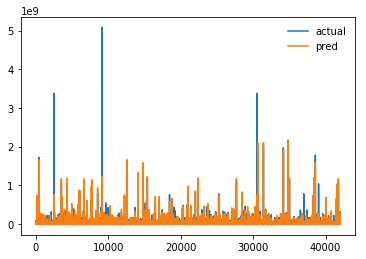

In [26]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [30]:
pred = test_func(model, X_test)


[[ 1.1156388e-03]
 [-6.8015093e-04]
 [ 7.5667631e-05]
 ...
 [-1.4134599e-03]
 [-6.0772523e-04]
 [-6.1683357e-04]]


In [28]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,5.902578e+06
1,BTshNOJyKHnT2YIT,-3.234494e+06
2,dhdymr0lV8N5kZOT,6.111504e+05
3,VEwyGGMcD56w5BOc,1.087098e+07
4,wmUeMoJZfsqaSX9b,-7.646944e+06
5,EtBjGAHmHCe9t7TZ,-3.833482e+05
6,hPNH34vmaZtvBtqc,1.320304e+07
7,wXjeI38bYDMJJwZC,3.751349e+06
8,fxZSGX6aPAFKU8W4,-5.572846e+06
9,ewr0Fx6ign87OwaV,3.285591e+06


## overfitting

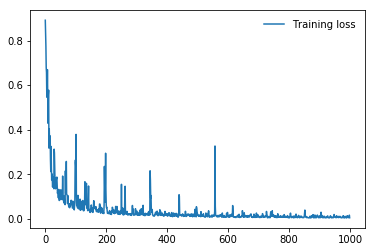

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

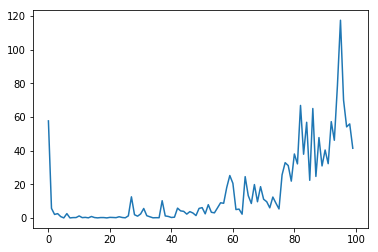

In [19]:
plt.plot(eval_losses, label='Validation loss')


## overfitting2

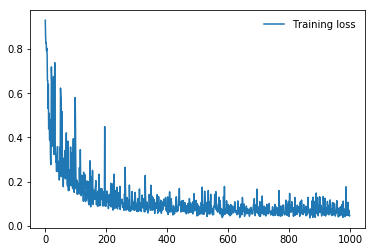

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

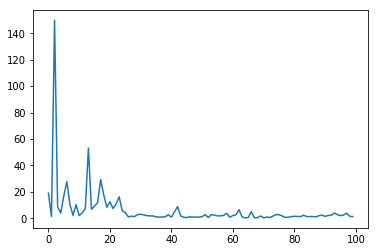

In [19]:
plt.plot(eval_losses, label='Validation loss')


### Submission

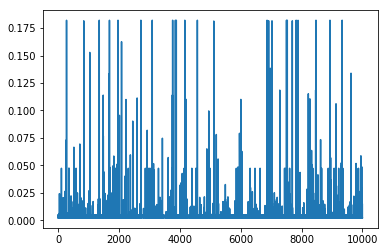

In [26]:
plt.plot(pred, label='pred')


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512

Result 2 lr=0.001, batch_size=64, DNN 233->256->128->64->1
after 1k loss : 0.00011785521522113447, can't decrease...
- x_scale false
- y_scale true


### question

why output is negative?